## Evaluation of diffusion model against benchmarks

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xss
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr
from read_data import get_cond_ecmwf_dataset, get_mean_std_data
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

2024-04-04 10:18:02.305447: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 10:18:02.362813: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 10:18:02.364164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 10:18:03.892627: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


##### Utils

In [97]:
def compute_metrics(qm, bilint, chirps, dim, diffusion=None):
    ### Benchmarks
    rmse, mae, r2, pearson, spearman = dict(), dict(), dict(), dict(), dict()

    rmse['qm'] = xss.rmse(qm, chirps, dim=dim)
    rmse['bilint'] = xss.rmse(bilint, chirps, dim=dim)
    
    mae['qm'] = xss.mae(qm, chirps, dim=dim)
    mae['bilint'] = xss.mae(bilint, chirps, dim=dim)

    r2['qm'] = xss.r2(qm, chirps, dim=dim)
    r2['qm'] = r2['qm'].where((r2['qm'] < 1e3) & (r2['qm'] > -1e3), np.nan)
    r2['bilint'] = xss.r2(bilint, chirps, dim=dim)
    r2['bilint'] = r2['bilint'].where((r2['bilint'] < 1e3) & (r2['bilint'] > -1e3), np.nan)

    pearson['qm'] = xss.pearson_r(qm, chirps, dim=dim)
    pearson['bilint'] = xss.pearson_r(bilint, chirps, dim=dim)

    spearman['qm'] = xss.spearman_r(qm, chirps, dim=dim)
    spearman['bilint'] = xss.spearman_r(bilint, chirps, dim=dim)
    
    if diffusion is not None:
        rmse['diffusion'] = xss.rmse(diffusion, chirps, dim=dim)
        mae['diffusion'] = xss.mae(diffusion, chirps, dim=dim)
        r2['diffusion'] = xss.r2(diffusion, chirps, dim=dim)
        r2['diffusion'] = r2['diffusion'].where((r2['diffusion'] < 1e3) & (r2['diffusion'] > -1e3), np.nan)
        pearson['diffusion'] = xss.pearson_r(diffusion, chirps, dim=dim)
        spearman['diffusion'] = xss.spearman_r(diffusion, chirps, dim=dim)
        
    return rmse, mae, r2, pearson, spearman

In [3]:
def plot_eval_metrics(rmse, mae, r2, pearson, spearman):
    if len(rmse['qm'].dims) == 2:
        
        fig, axs = plt.subplots(5, 3, figsize=(12, 12))

        # RMSE
        axs[0, 0].imshow(rmse['bilint'])
        axs[0, 1].imshow(rmse['qm'])
        im = axs[0, 2].imshow(rmse['diffusion'])
        fig.colorbar(im, ax=axs[0, :])
        axs[0, 0].set(ylabel='RMSE')

        # MAE
        axs[1, 0].imshow(mae['bilint'])
        axs[1, 1].imshow(mae['qm'])
        im = axs[1, 2].imshow(mae['diffusion'])
        fig.colorbar(im, ax=axs[1, :])
        axs[1, 0].set(ylabel='MAE')

        # R2
        axs[2, 0].imshow(r2['bilint'])
        axs[2, 1].imshow(r2['qm'])
        im = axs[2, 2].imshow(r2['diffusion'])
        fig.colorbar(im, ax=axs[2, :])
        axs[2, 0].set(ylabel='R2')

        # PEARSON
        axs[3, 0].imshow(pearson['bilint'])
        axs[3, 1].imshow(pearson['qm'])
        im = axs[3, 2].imshow(pearson['diffusion'])
        fig.colorbar(im, ax=axs[3, :])
        axs[3, 0].set(ylabel='Pearson')

        # SPEARMAN
        axs[4, 0].imshow(spearman['bilint'])
        axs[4, 1].imshow(spearman['qm'])
        im = axs[4, 2].imshow(spearman['diffusion'])
        fig.colorbar(im, ax=axs[4, :])
        axs[4, 0].set(ylabel='Spearman')

        # Define column names
        axs[0, 0].set_title('Bilinear interpolation')
        axs[0, 1].set_title('Quantile Mapping')
        axs[0, 2].set_title('Diffusion')

        # Hide x labels and tick labels for top plots and y ticks for right plots.
        for ax in axs.flat:
            ax.label_outer()
            
    else:
        
        fig, axs = plt.subplots(5, 1, figsize=(12, 12))

        # RMSE
        axs[0].plot(rmse['bilint'], label='bilinear interp')
        axs[0].plot(rmse['qm'], label='quantile mapping')
        axs[0].plot(rmse['diffusion'], label='diffusion')
        axs[0].legend()
        axs[0].set(ylabel='RMSE')

        # MAE
        axs[1].plot(mae['bilint'], label='bilinear interp')
        axs[1].plot(mae['qm'], label='quantile mapping')
        axs[1].plot(mae['diffusion'], label='diffusion')
        axs[1].legend()
        axs[1].set(ylabel='MAE')

        # R2
        axs[2].plot(r2['bilint'], label='bilinear interp')
        axs[2].plot(r2['qm'], label='quantile mapping')
        axs[2].plot(r2['diffusion'], label='diffusion')
        axs[2].legend()
        axs[2].set(ylabel='R2')

        # PEARSON
        axs[3].plot(pearson['bilint'], label='bilinear interp')
        axs[3].plot(pearson['qm'], label='quantile mapping')
        axs[3].plot(pearson['diffusion'], label='diffusion')
        axs[3].legend()
        axs[3].set(ylabel='Pearson')

        # SPEARMAN
        axs[4].plot(spearman['bilint'], label='bilinear interp')
        axs[4].plot(spearman['qm'], label='quantile mapping')
        axs[4].plot(spearman['diffusion'], label='diffusion')
        axs[4].legend()
        axs[4].set(ylabel='Spearman')

        # Hide x labels and tick labels for top plots and y ticks for right plots.
        for ax in axs.flat:
            ax.label_outer()

In [95]:
def display_metrics_table(rmse, mae, r2, pearson, spearman):
    df_metrics = pd.DataFrame(
        data=np.array([
            [np.nanmean(rmse['bilint']), np.nanmean(rmse['qm']), np.nanmean(rmse['diffusion'])],
            [np.nanmean(mae['bilint']), np.nanmean(mae['qm']), np.nanmean(mae['diffusion'])],
            [np.nanmean(r2['bilint']), np.nanmean(r2['qm']), np.nanmean(r2['diffusion'])],
            [np.nanmean(pearson['bilint']), np.nanmean(pearson['qm']), np.nanmean(pearson['diffusion'])],
            [np.nanmean(spearman['bilint']), np.nanmean(spearman['qm']), np.nanmean(spearman['diffusion'])],
        ]),
        index=['RMSE', 'MAE', 'R2', 'Pearson', 'Spearman'],
        columns=['Bilinear', 'Quantile Mapping', 'Diffusion'],
    )
    display(df_metrics)

##### **Read forecasts and chirps** 

In [5]:
ecmwf = xr.open_mfdataset('data/test/*.zarr').ecmwf.load()
chirps = xr.open_mfdataset('data/test/*.zarr').chirps.load()

##### **Read benchmarks** 

In [6]:
qm = xr.open_zarr('data/benchmarks_results/QM/test_quantile_mapping.zarr').scen.load()
climax = xr.open_zarr('data/benchmarks_results/ClimaX/test_climax.zarr')
bilint = xr.open_zarr('data/benchmarks_results/bilinear/test_bilinear.zarr').bilint.load()

##### **Compute metrics**

In [46]:
### Get mean and var for de-normalizing
mean_chirps, var_chirps, mean_ecmwf, var_ecmwf = get_mean_std_data(split="train")

In [86]:
### Benchmarks
rmse_time, mae_time, r2_time, pearson_time, spearman_time = compute_metrics(qm, bilint, chirps, dim='time')

rmse_space, mae_space, r2_space, pearson_space, spearman_space = compute_metrics(qm, bilint, chirps, dim=['longitude','latitude'])

In [87]:
### Evaluate diffusion model with simple metrics
batch_test = next(iter(get_cond_ecmwf_dataset(split="test", batch_size=ecmwf.time.size)))

test_batch_cond = batch_test["cond"]['channel:low_res']
test_batch_gt = batch_test["x"]

xx = np.load(f"data/diffusion/batch_25samples.npy")

rmse_time['diffusion'], mae_time['diffusion'], r2_time['diffusion'], pearson_time['diffusion'], spearman_time['diffusion'] = np.zeros((28, 28)), np.zeros((28, 28)), np.zeros((28, 28)), np.zeros((28, 28)), np.zeros((28, 28))

for i in range(test_batch_cond.shape[1]):
    for j in range(test_batch_cond.shape[2]):
        pred = np.mean(xx, axis=1)[:, i, j, 0]  * (var_chirps + 1e-4) + mean_chirps
        ground_truth = test_batch_gt[:, i, j, 0]  * (var_chirps + 1e-4) + mean_chirps
        
        rmse_time['diffusion'][i, j] = root_mean_squared_error(ground_truth, pred)
        mae_time['diffusion'][i, j] = mean_absolute_error(ground_truth, pred)
        r2_time['diffusion'][i, j] = r2_score(ground_truth, pred)
        pearson_time['diffusion'][i, j] = pearsonr(ground_truth, pred).statistic
        spearman_time['diffusion'][i, j] = spearmanr(ground_truth, pred).statistic
        
rmse_space['diffusion'], mae_space['diffusion'], r2_space['diffusion'], pearson_space['diffusion'], spearman_space['diffusion'] = np.zeros(ecmwf.time.size), np.zeros(ecmwf.time.size), np.zeros(ecmwf.time.size), np.zeros(ecmwf.time.size), np.zeros(ecmwf.time.size)

for t in range(test_batch_cond.shape[0]):
    pred = np.mean(xx, axis=1)[t, :, :, 0]  * (var_chirps + 1e-4) + mean_chirps
    ground_truth = test_batch_gt[t, :, :, 0]  * (var_chirps + 1e-4) + mean_chirps

    rmse_space['diffusion'][t] = root_mean_squared_error(ground_truth, pred)
    mae_space['diffusion'][t] = mean_absolute_error(ground_truth, pred)
    r2_space['diffusion'][t] = r2_score(ground_truth, pred)
    pearson_space['diffusion'][t] = pearsonr(ground_truth.flatten(), pred.flatten()).statistic
    spearman_space['diffusion'][t] = spearmanr(ground_truth.flatten(), pred.flatten()).statistic  
    
r2_space['diffusion'] = np.where(r2_space['diffusion']<-1e3, np.nan, r2_space['diffusion'])

##### **Plot simple metrics** (go to inference nb to inspect random images / time series)

\<metric\> across time

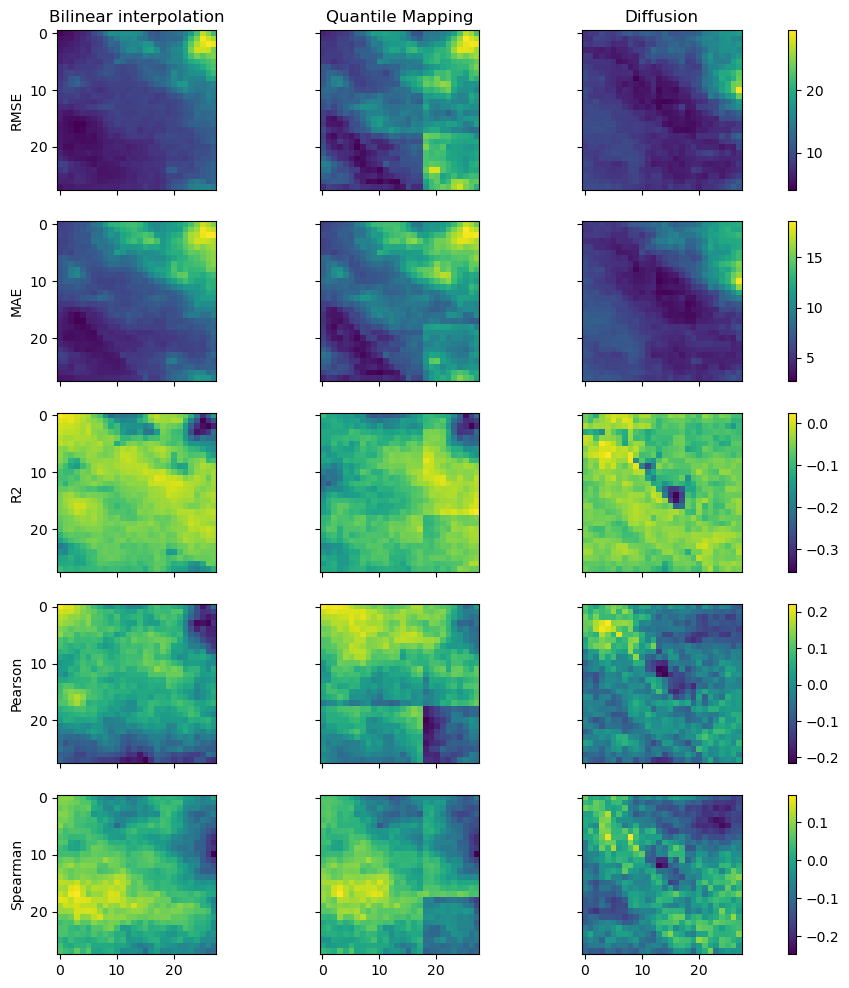

In [74]:
plot_eval_metrics(rmse_time, mae_time, r2_time, pearson_time, spearman_time)

In [92]:
display_metrics_table(rmse_time, mae_time, r2_time, pearson_time, spearman_time)

,Bilinear,Quantile Mapping,Diffusion
RMSE,41.730533,42.135738,9.167076
MAE,26.132520,25.652172,6.253671
R2,0.236625,0.147244,-0.064471
Pearson,0.593546,0.558478,-0.015425
Spearman,0.730577,0.719076,-0.046779


\<metric\> across pixels

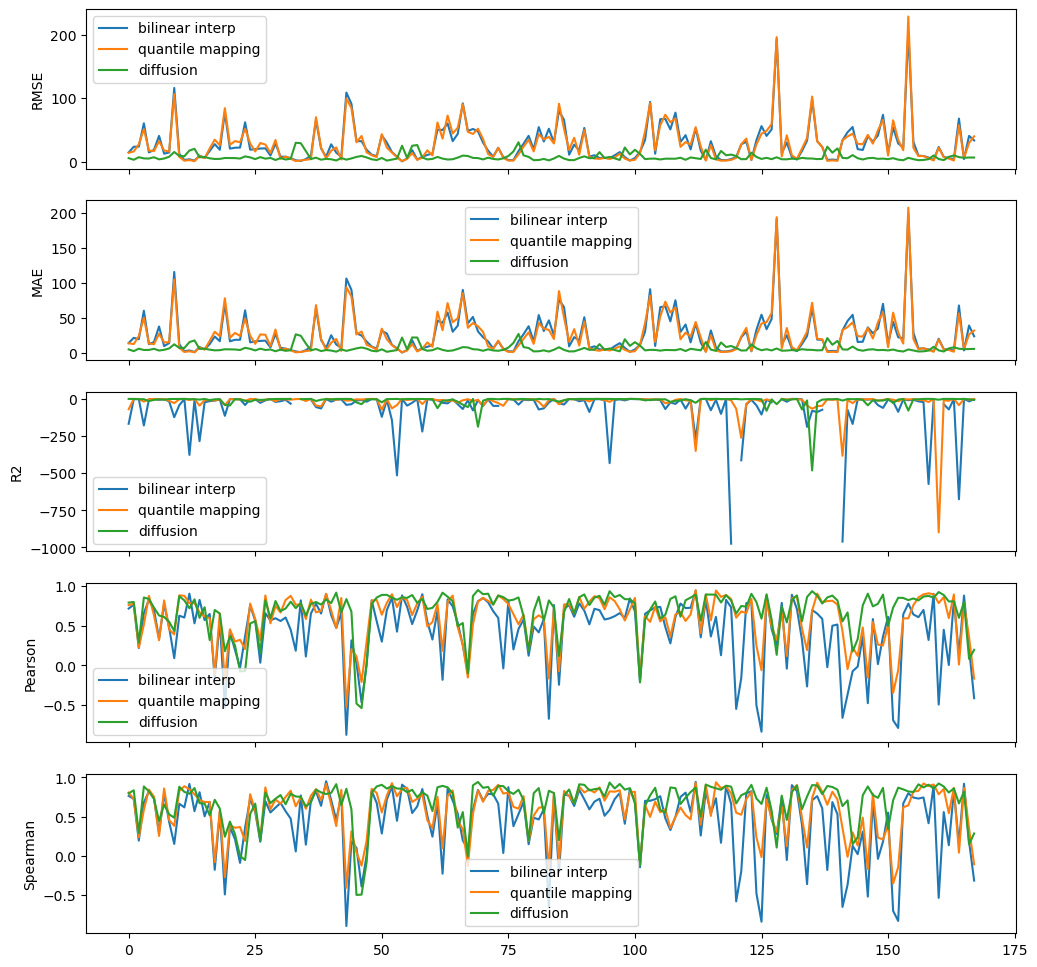

In [93]:
plot_eval_metrics(rmse_space, mae_space, r2_space, pearson_space, spearman_space)

In [96]:
display_metrics_table(rmse_space, mae_space, r2_space, pearson_space, spearman_space)

,Bilinear,Quantile Mapping,Diffusion
RMSE,28.953485,28.862873,7.436464
MAE,26.132520,25.652172,6.253671
R2,-61.082839,-21.735146,-10.685568
Pearson,0.430259,0.580485,0.692318
Spearman,0.445674,0.576156,0.698974


histogram (pred - chirps)

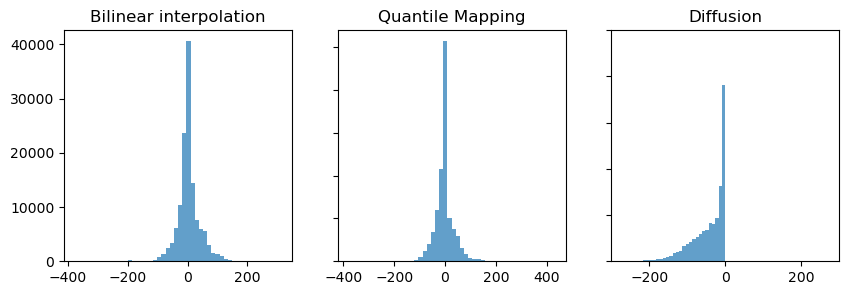

In [140]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

ax1.hist((bilint - chirps).values.ravel(), bins=50, alpha=0.7)
ax1.set_title("Bilinear interpolation")

ax2.hist((qm - chirps).values.ravel(), bins=50, alpha=0.7)
ax2.set_title("Quantile Mapping")

pred = np.mean(xx, axis=1)[:,:,:,0]
ax3.hist((pred - chirps.transpose('time', 'latitude', 'longitude').values).ravel(), bins=50, alpha=0.7)
ax3.set_title("Diffusion")

plt.xlim(-300, 300)
plt.ylim(0, 50000)

for ax in [ax1, ax2, ax3]:
    ax.label_outer()
    
plt.show()

##### **Compare SPI** 

In [112]:
spi_diffusion = xr.open_zarr('data/diffusion/test_diffusion_spi.zarr').__xarray_dataarray_variable__ / 1000
spi_bilint = xr.open_zarr('data/benchmarks_results/bilinear/test_bilint_spi.zarr').tp / 1000
spi_qm = xr.open_zarr('data/benchmarks_results/QM/test_qm_spi.zarr').scen / 1000

spi_gt = xr.open_zarr('data/test_spi_chirps.zarr').chirps / 1000

In [113]:
# Compute metrics on SPI
rmse_spi_time, mae_spi_time, r2_spi_time, pearson_spi_time, spearman_spi_time = compute_metrics(spi_qm, spi_bilint, spi_gt, 'time', spi_diffusion)
rmse_spi_space, mae_spi_space, r2_spi_space, pearson_spi_space, spearman_spi_space = compute_metrics(spi_qm, spi_bilint, spi_gt, ['latitude', 'longitude'], spi_diffusion)

\<metric\> across time

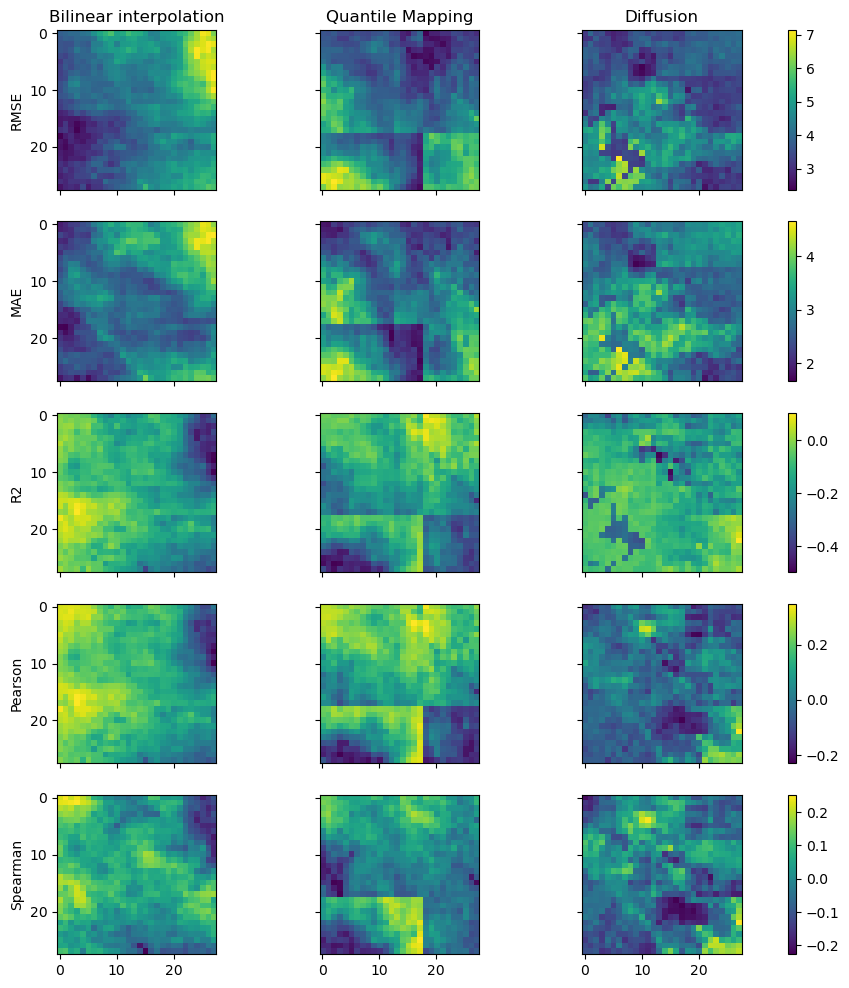

In [114]:
# Plot
plot_eval_metrics(rmse_spi_time, mae_spi_time, r2_spi_time, pearson_spi_time, spearman_spi_time)

In [115]:
display_metrics_table(rmse_spi_time, mae_spi_time, r2_spi_time, pearson_spi_time, spearman_spi_time)

,Bilinear,Quantile Mapping,Diffusion
RMSE,0.735442,0.718702,4.031513
MAE,0.593593,0.575214,3.059134
R2,0.581301,0.546426,-0.129053
Pearson,0.782516,0.769435,-0.016384
Spearman,0.787092,0.778518,-0.028766


\<metric\> across pixels

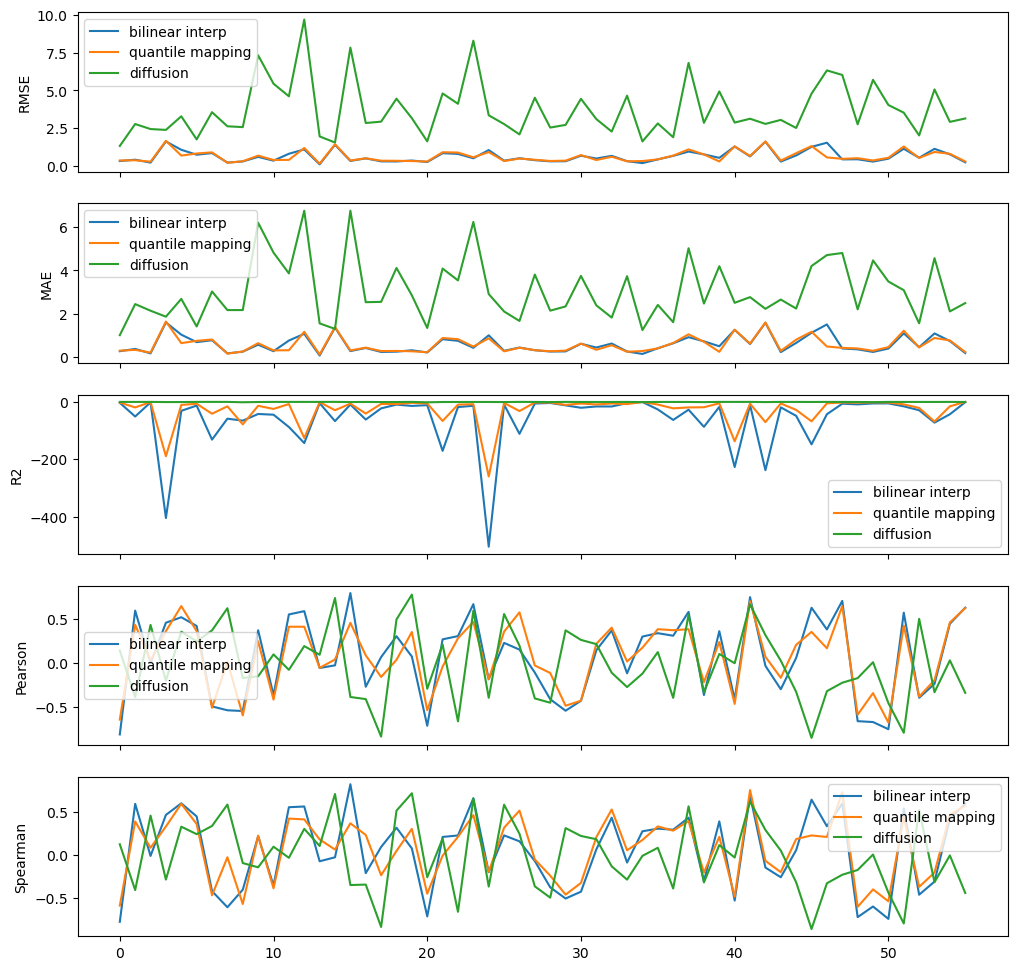

In [116]:
plot_eval_metrics(rmse_spi_space, mae_spi_space, r2_spi_space, pearson_spi_space, spearman_spi_space)

In [117]:
display_metrics_table(rmse_spi_space, mae_spi_space, r2_spi_space, pearson_spi_space, spearman_spi_space)

,Bilinear,Quantile Mapping,Diffusion
RMSE,0.627717,0.619589,3.694705
MAE,0.593593,0.575214,3.059134
R2,-59.422642,-28.132565,-0.249817
Pearson,0.061974,0.074087,-0.010723
Spearman,0.054103,0.076353,-0.008939


##### **Compare drought outcome (SPI<t): ROC scores** 

In [105]:
DROUGHT_THRESHOLD = -1.

In [106]:
outcome_diffusion = (xr.open_zarr('data/diffusion/test_diffusion_spi.zarr').__xarray_dataarray_variable__ / 1000 < DROUGHT_THRESHOLD).astype(int)
outcome_bilint = (xr.open_zarr('data/benchmarks_results/bilinear/test_bilint_spi.zarr').tp / 1000 < DROUGHT_THRESHOLD).astype(int)
outcome_qm = (xr.open_zarr('data/benchmarks_results/QM/test_qm_spi.zarr').scen / 1000 < DROUGHT_THRESHOLD).astype(int)

outcome_gt = (xr.open_zarr('data/test_spi_chirps.zarr').chirps / 1000 < DROUGHT_THRESHOLD).astype(int)

In [107]:
# Compute roc score
roc_score = dict()

roc_score['diffusion'] = xss.roc(outcome_gt, outcome_diffusion, dim='time', return_results="area")
roc_score['qm'] = xss.roc(outcome_gt, outcome_qm, dim='time', return_results="area")
roc_score['bilint'] = xss.roc(outcome_gt, outcome_bilint, dim='time', return_results="area")

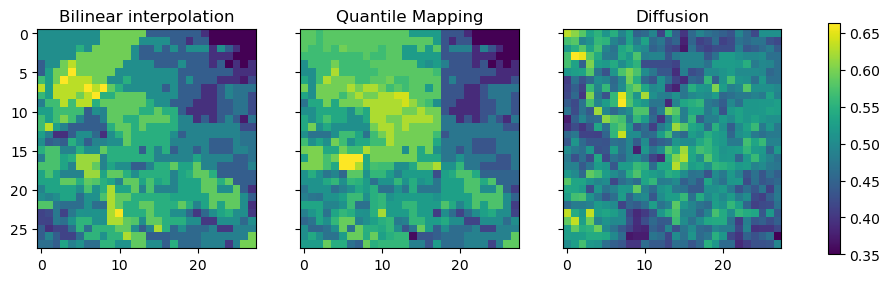

In [108]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

ax1.imshow(roc_score['bilint'].values)
ax1.set_title('Bilinear interpolation')
ax1.label_outer()

ax2.imshow(roc_score['qm'].values)
ax2.set_title('Quantile Mapping')
ax2.label_outer()

im = ax3.imshow(roc_score['diffusion'].values)
ax3.set_title('Diffusion')
ax3.label_outer()

fig.colorbar(im, ax=(ax1, ax2, ax3))

In [109]:
pd.DataFrame(
    data=np.array([[np.mean(roc_score['bilint']), np.mean(roc_score['qm']), np.mean(roc_score['diffusion'])]]),
    index=['ROC score'],
    columns=['Bilinear', 'Quantile Mapping', 'Diffusion'],
)

,Bilinear,Quantile Mapping,Diffusion
ROC score,0.797727,0.805273,0.492243
